# **Logistic and linear regression with deterministic and stochastic first order methods**

    Ecole Polytechnique | (Lab 2) : Optimisation - DataScience Master
    Authors : Alexandre Gramfort, Hicham Janati
   
The aim of this lab is to implement and compare various batch and stochastic algorithms for linear and logistic regression with ridge penalization. 

The following methods are compared in this notebook.

**Batch (deterministic) methods**

- gradient descent (GD)
- accelerated gradient descent (AGD)

**Stochastic algorithms**

- stochastic gradient descent (SGD)
- stochastic averaged gradient (SAG)
- stochastic variance reduced gradient (SVRG)

Note that we consider as use-cases logistic and linear regression with ridge penalization only, although most of the algorithms below can be used with many other models, and other types of penalization, even non-smooth ones, such as the $\ell_1$ penalization.

---

## **VERY IMPORTANT**

- This work **must be done by pairs of students**.
- **Each** student must send their work using the **moodle platform**, please
  check the deadline on moodle.
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

--- 
### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "bryan"
ln1 = "chen"
fn2 = "alice"
ln2 = "devilder"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab2", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab2_chen_bryan_and_devilder_alice.ipynb


### **Gentle reminder: no evaluation if you don't respect this EXACTLY**

----

### **Table of content**

[1. Loss functions, gradients and step-sizes](#loss)<br>
[2. Generate a dataset](#data)<br>
[3. Deterministic methods](#batch)<br>
[4. Stochastic methods](#stoc)<br>
[5. Numerical comparison](#comp)<br>
[6. Conclusion](#conc)<br>

----

### **Import librairies and configuration**

In [2]:
%matplotlib inline

In [3]:
from time import time

import numba
import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt
from numba import njit

In [4]:
# choose a large font size by default and use tex for math
usetex = False  # change this to True if you have a working LaTeX install

fontsize = 16
params = {
    "axes.labelsize": fontsize + 2,
    "font.size": fontsize + 2,
    "legend.fontsize": fontsize + 2,
    "xtick.labelsize": fontsize,
    "ytick.labelsize": fontsize,
    "text.usetex": usetex,
}
plt.rcParams.update(params)

--- 
<a id='numba'></a>
## **0. Make sure Numba is correctly installed**
Instructions available at: http://numba.pydata.org/numba-doc/latest/user/installing.html

In [5]:
print(numba.__version__) # Your version of Numba

0.60.0


In [6]:
@njit
def go_fast(a): # Function is compiled to machine code when called the first time
    trace = 0.0
    # assuming square input matrix
    for i in range(a.shape[0]):   # Numba likes loops
        trace += np.tanh(a[i, i]) # Numba likes NumPy functions
    return a + trace              # Numba likes NumPy broadcasting

x = np.arange(100).reshape(10, 10)
x = x.astype(float)
go_fast(x) # Running a first time the function to compile it

array([[  9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.],
       [ 19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.],
       [ 29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.],
       [ 39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.],
       [ 49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.],
       [ 59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.],
       [ 69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.],
       [ 79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.],
       [ 89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.],
       [ 99., 100., 101., 102., 103., 104., 105., 106., 107., 108.]])

In [7]:
np.tanh(0)+ np.tanh(10) + np.tanh(20)

1.9999999958776926

Iteration time of the Numba-compiled function.

In [8]:
%timeit go_fast(x)

638 ns ± 7.13 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


Numba-compiled function have a special `.py_func` attribute which is the original uncompiled Python function.  Iteration time of the uncompiled function should be greater.

In [9]:
%timeit go_fast.py_func(x)

6.86 µs ± 34 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


----

<a id='loss'></a>
## **1. Loss functions, gradients and step-sizes**


We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2
$$
where
- $\ell(z, b) = \frac 12 (b - z)^2$ (least-squares regression)
- $\ell(z, b) = \log(1 + \exp(-bz))$ (logistic regression).

We write it as a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(x)
$$
where
$$
f_i(x) = \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2.
$$

For each cases, the gradients are
$$
\nabla f_i(x) = (a_i^\top x - b_i) a_i + \lambda x
$$
and
$$
\nabla f_i(x) = - \frac{b_i}{1 + \exp(b_i a_i^\top x)} a_i + \lambda x.
$$

Denote by $L$ (resp. $L_i$) the Lipschitz constant of $f$ (resp. $f_i$) and $\mathbf A^\top = [a_1, \ldots, a_n].$
One can easily see (using $\|\cdot\|_{2}$ for the matrix spectrale norm) that for least-squares regression
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{n} + \lambda \quad \text{ and } L_i = \| a_i \|_2^2 + \lambda
$$
while for logistic regression it is
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{4 n} + \lambda \quad \text{ and } L_i = \frac 14 \| a_i \|_2^2 + \lambda.
$$
For full-gradient methods, the theoretical step-size is $1 / L$, while for SAG and SVRG (see below) it can be taken as
$1 / (\max_{i=1,\ldots,n} L_i)$

We now introduce functions that will be used for the solvers.


In [10]:
@njit    
def grad_i_linreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    return (a_i.dot(x) - b[i]) * a_i + lbda * x


@njit
def grad_linreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_linreg(i, x, A, b, lbda)
    return g / n


def loss_linreg(x, A, b, lbda):
    return norm(A.dot(x) - b) ** 2 / (2. * n) + lbda * norm(x) ** 2 / 2.


def lipschitz_linreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / n + lbda

In [11]:
@njit    
def grad_i_logreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    b_i = b[i]
    return - a_i * b_i / (1. + np.exp(b_i * np.dot(a_i, x))) + lbda * x


@njit
def grad_logreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_logreg(i, x, A, b, lbda)
    return g / n


def loss_logreg(x, A, b, lbda):
    bAx = b * np.dot(A, x)
    return np.mean(np.log(1. + np.exp(- bAx))) + lbda * norm(x) ** 2 / 2.


def lipschitz_logreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / (4. * n) + lbda

----

<a id='data'></a>
## **2. Generate a dataset**

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [12]:
from numpy.random import multivariate_normal, randn
from scipy.linalg import toeplitz


def simu_linreg(x, n, std=1., corr=0.5):
    """Simulation for the least-squares problem.

    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    b = A.dot(x) + noise
    return A, b

In [13]:
def simu_logreg(x, n, std=1., corr=0.5):
    """Simulation for the logistic regression problem.
    
    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size    
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """    
    A, b = simu_linreg(x, n, std=1., corr=corr)
    return A, np.sign(b)

In [14]:
d = 50
n = 10000
idx = np.arange(d)

# Ground truth coefficients of the model
x_model_truth = (-1)**idx * np.exp(-idx / 10.)

_A, _b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
#_A, _b = simu_logreg(x_model_truth, n, std=1., corr=0.7)

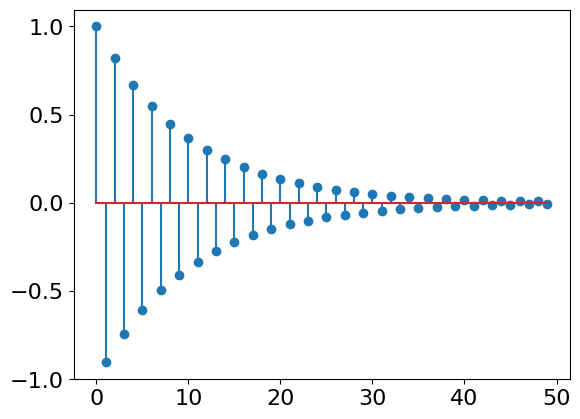

In [15]:
plt.stem(x_model_truth);

### Numerically check loss and gradient

In [16]:
from scipy.optimize import check_grad

lbda = 1. / n ** (0.5)

A, b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_linreg, grad_linreg, np.random.randn(d), A, b, lbda)

8.390183928644258e-06

In [17]:
lbda = 1. / n ** (0.5)

A, b = simu_logreg(x_model_truth, n, std=1., corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_logreg, grad_logreg, np.random.randn(d), A, b, lbda)

1.9926272994784255e-07

### Choice of the model

In [18]:
A, b = simu_linreg(x_model_truth, n, std=1., corr=0.9)
loss = loss_linreg
grad = grad_linreg
grad_i = grad_i_linreg
lipschitz_constant = lipschitz_linreg
lbda = 1. / n ** (0.5)

### Compute the theoretical step-size for gradient descent

In [19]:
step = 1. / lipschitz_constant(A, b, lbda)

print("step = %s" % step)

step = 0.06393968165366533


### Get a very precise minimum to compute distances to minimum

Here we use L-BFGS that you have not seen yet. Just take the estimated `x_min` and move on.
You will see L-BFGS later in the course.

In [20]:
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad,
                                args=(A, b, lbda), pgtol=1e-30, factr=1e-30)


print(f_min)
print(norm(grad_linreg(x_min, A, b, lbda)))

0.5241863721978931
3.261499222479885e-08


--- 
<a id='batch'></a> 

## **3. Deterministic/Batch methods (GD, AGD)**

### Define a class to monitor iterations

In [21]:
class monitor:
    def __init__(self, algo, loss, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.loss = loss
        self.args = args
        self.f_min = loss(x_min, *args)
    
    def run(self, *algo_args, **algo_kwargs):
        t0 = time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time() - t0
        self.x_list = x_list
        self.err = [norm(x - self.x_min) for x in x_list]
        self.obj = [self.loss(x, *self.args) - self.f_min for x in x_list]

In [22]:
# Number of iterations
n_iter = 200

### Gradient descent (GD)

We recall that an iteration of batch gradient writes

$$
x_{k+1} \gets x_k - \eta \nabla f(x_k)
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the GD solver in the cell below

In [23]:
@njit
def gd(x_init, grad, n_iter=100, step=1., store_every=1, args=()):
    """Gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        ### TODO
        x -= step * grad(x, *args)
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [24]:
step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_gd = monitor(gd, loss, x_min, (A, b ,lbda))
monitor_gd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### Accelerated Gradient Descent (AGD)

We recall that an iteration of AGD (see FISTA) writes:

$$
\begin{align*}
x_{k+1} &\gets y_k - \eta \nabla f(y_k) \\
t_{k+1} &\gets \frac{1 + \sqrt{1 + 4 t_k^2}}{2} \\
y_{k+1} &\gets x_{k+1} + \frac{t_k-1}{t_{k+1}} (x_{k+1} - x_k)
\end{align*}
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipschitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the AGD solver in the cell below

In [25]:
@njit
def agd(x_init, grad, n_iter=100, step=1., args=(), store_every=1):
    """Accelerated Gradient Descent algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    x_list = []
    for i in range(n_iter):
        if i % store_every == 0:
            x_list.append(x.copy())
        ### TODO
        x_new = y - step * grad(y, *args)
        t_new = (1 + np.sqrt(1 + 4 * t ** 2)) / 2
        y = x_new + (t - 1) / t_new * (x_new - x)

        x = x_new
        t = t_new
    return x, x_list

In [26]:
step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_agd = monitor(agd, loss, x_min, (A, b ,lbda))
monitor_agd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### A first numerical comparison of deterministic solvers

First, define some plotting functions.

In [27]:
def plot_epochs(monitors, solvers):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    for monit in monitors:
        plt.semilogy(monit.obj, lw=2)
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.ylabel("objective")
    plt.grid()
    plt.legend(solvers)

    plt.subplot(1, 2, 2)

    for monit in monitors:
        plt.semilogy(monit.err, lw=2)
        plt.title("Distance to optimum")
        plt.xlabel("Epoch")
        plt.ylabel("$\|x_k - x^*\|_2$")
    plt.grid()
    plt.legend(solvers)
    

def plot_time(monitors, solvers, xscale='linear', yscale='log'):
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")
        plt.yscale(yscale)
        plt.xscale(xscale)
    plt.grid()

    plt.legend(solvers)

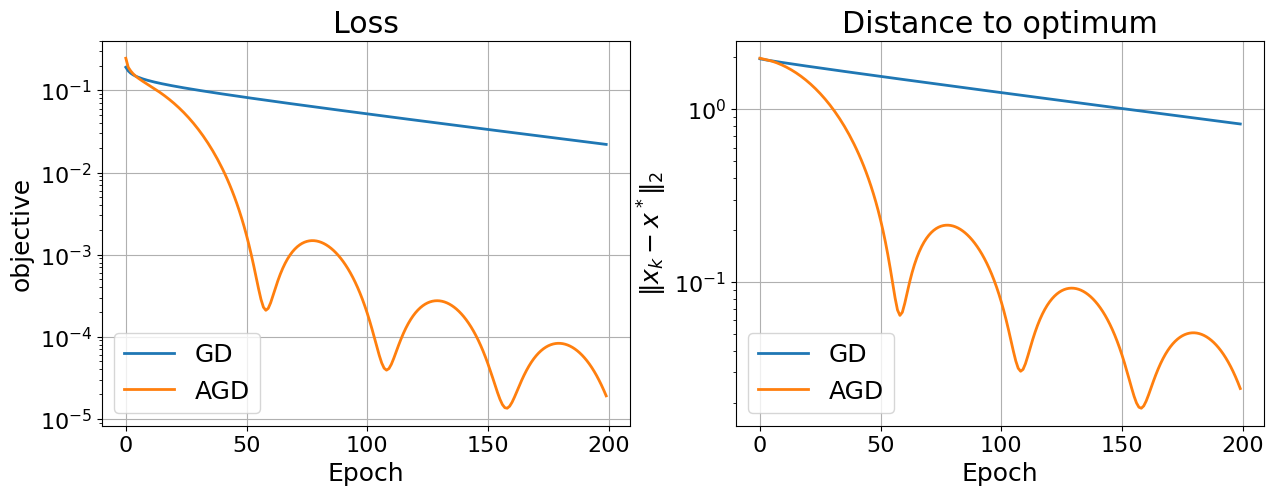

In [28]:
monitors = [monitor_gd, monitor_agd]

solvers = ["GD", "AGD"]

plot_epochs(monitors, solvers)

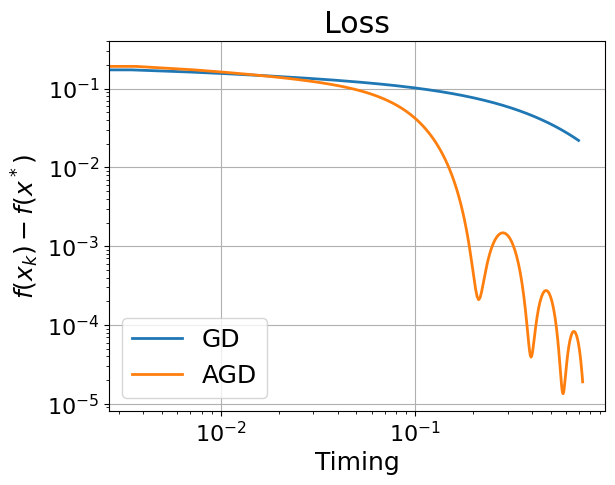

In [29]:
plot_time(monitors, solvers, xscale='log')

### First conclusions

*QUESTIONS*:

- Give some first conclusions about the batch solver studied here
- What do you observe about AGD? is it suprising ?

**Answers**:

Q1/ Concerning the loss plot, we can see that the loss decreases faster with AGD than with GD, which is expected since AGD is an accelerated version of GD. 

Indeed, the AGD algorithm has a $O(\frac{1}{k^2})$ convergence rate for $L$-smooth functions and a step size of $\frac{1}{L}$: 

$$F(x^{(k)}) - F(x^{*}) \leq \frac{2L \lVert x^{(0)}-x^{*} \rVert}{k^2} $$

whereas the GD algorithm has a $O(\frac{1}{k})$ convergence rate for $L$-smooth functions and a step size of $\rho \leq \frac{1}{L}$:

$$F(x^{(k)}) - F(x^{*}) \leq \frac{\lVert x^{(0)}-x^{*} \rVert}{k} $$

The same observation can be made for the distance to minimum plot. The distance to minimum decreases faster with AGD than with GD. We observe that there are some oscillations due to the acceleration of the algorithm (AGD) - the momentum term. 

Concerning the time plot, we can see that AGD is slower than GD in terms of computation time. Within one loop for each method, we have 2 more computations for AGD than for GD. 



Q2/ The fact that the AGD is slower than GD in terms of computation time may be surprising, because as the name suggests, AGD is an accelerated version of GD. However, the computation of the acceleration term in AGD may be more expensive than the computation of the gradient in GD. This could explain why AGD is slower than GD in terms of computation time.

----

<a id='stoc'></a> 
## **4. Stochastic methods**

In [30]:
n_iter = 50

# generate indices of random samples
random_indices = np.random.randint(0, n, n * n_iter)

In [31]:
print(random_indices)
print(random_indices.shape)

[6916 4369 8999 ... 3029 1097 3465]
(500000,)


### **Implement the SGD solver**

We recall that an iteration of SGD writes

- Pick $i$ uniformly at random in $\{1, \ldots, n\}$
- Apply
$$
x_{t+1} \gets x_t - \frac{\eta_0}{\sqrt{t+1}} \nabla f_i(x_t)
$$

where $\eta_0$ is a step-size to be tuned by hand.

*QUESTION*:
- Fill in the iteration of the SGD solver in the cell below

In [32]:
@njit
def sgd(x_init, random_indices, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for idx in range(n_iter):
        i = random_indices[idx]
        
        ### TODO
        x -= step * grad_i(i, x, *args) / (np.sqrt(idx+1))
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [33]:
step0 = 1e-1
x_init = np.zeros(d)

monitor_sgd = monitor(sgd, loss, x_min, (A, b ,lbda))
monitor_sgd.run(x_init, random_indices, grad_i, n_iter * n, step0, args=(A, b, lbda))

### **BONUS: Implement the SGD with Averaging (SGDA) solver**

We recall that an iteration of SGDA writes

- Pick $i$ uniformly at random in $\{1, \ldots, n\}$
- Apply
$$
x_{t+1} \gets x_t - \frac{\eta_0}{\sqrt{t+1}} \nabla f_i(x_t)
$$
- Apply if $t \geq s_0$ then : 
$$ \bar{\mathbf{x}}_t = \frac{1}{t - s_0} \sum_{i=s_0}^{t} \mathbf{x}_{i} $$
- Else, apply : 
$$ \bar{\mathbf{x}}_t = \mathbf{x}_t$$

where $\eta_0$ is a step-size to be tuned by hand, and $s_0 \geq 0$ is the number of iterations before starting averaging.

<!-- 1. Initialize $ \mathbf{x}^{(0)} $, set $ s_0 \geq 0 $ -->
<!-- 2. For $ k = 0, 1, 2, \dots $ do -->
<!-- 3. &nbsp;&nbsp;&nbsp;&nbsp; $ i^{(k)} \leftarrow $ randomly pick an index $ i \in \{1, \dots, n\} $ -->
<!-- 4. $ \mathbf{d}^{(k)} \leftarrow - \nabla_{\mathbf{x}} f_{i^{(k)}}(\mathbf{x}^{(k)}) $
5. $ \mathbf{x}^{(k+1)} \leftarrow \mathbf{x}^{(k)} + \rho^{(k)} \mathbf{d}^{(k)} $
6. If $ k \geq s_0 $ then
7. $ \bar{\mathbf{x}}^{(k)} = \frac{1}{k - s_0} \sum_{i=s_0}^{k} \mathbf{x}^{(i)} $
8. Else
    9. $ \bar{\mathbf{x}}^{(k)} = \mathbf{x}^{(k)} $
10. End if
11. End for -->


In [34]:
@njit
def sgda(x_init, random_indices, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic gradient descent with averaging algorithm."""
    
    s0 = int(n_iter / 2) 
    x = x_init.copy() 
    x_list = []  
    avg_x = np.zeros_like(x) 
    
    for idx in range(n_iter):
        i = random_indices[idx]  
        grad = grad_i(i, x, *args)  
        x -= step * grad / np.sqrt(idx + 1)

        if idx >= s0:
            avg_x = (avg_x * (idx - s0) + x) / (idx - s0 + 1)

        if idx % store_every == 0:
            if idx >= s0:
                x_list.append(avg_x.copy())
            else:
                x_list.append(x.copy())
    
    return avg_x if n_iter > s0 else x, x_list

In [35]:
step0 = 1e-1
x_init = np.zeros(d)

monitor_sgda = monitor(sgda, loss, x_min, (A, b ,lbda))
monitor_sgda.run(x_init, random_indices, grad_i, n_iter * n, step0, args=(A, b, lbda))

### **Comparison SGD and SGDA**

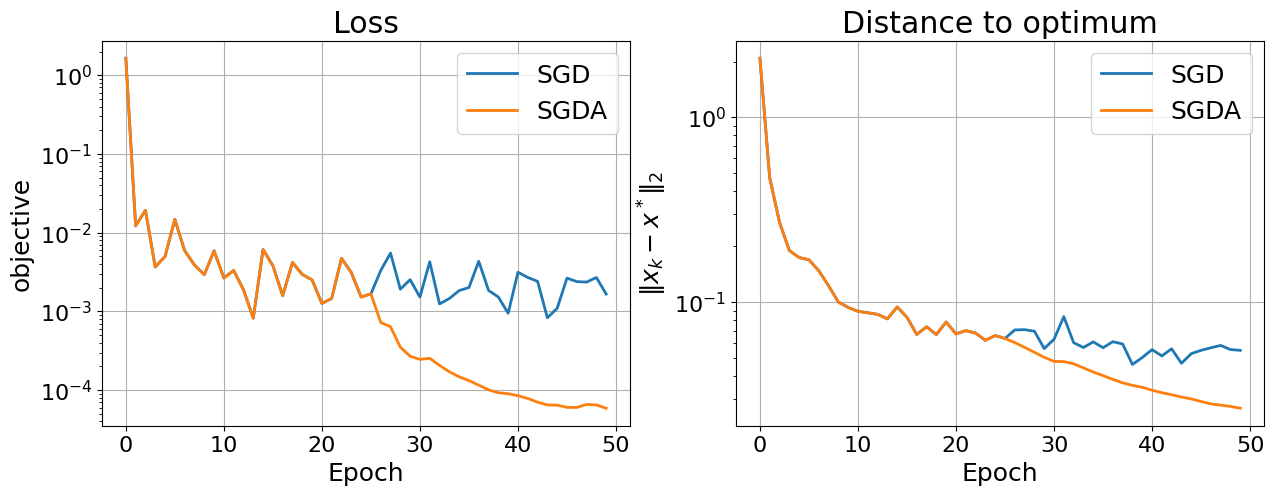

In [36]:
monitors = [monitor_sgd, monitor_sgda]

solvers = ["SGD", "SGDA"]

plot_epochs(monitors, solvers)

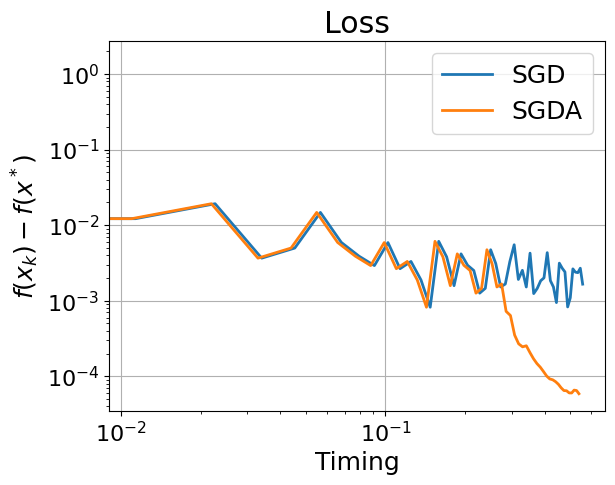

In [37]:
plot_time(monitors, solvers, xscale='log')

----

### **Implement the SAG solver**

We recall that an iteration of SAG writes

For $t=1, \ldots, $ until convergence

1. Pick $i_t$ uniformly at random in $\{1, \ldots, n\}$

2. Update the average of gradients
$$
G_t \gets \frac 1n \sum_{i=1}^n g_i^t
$$
where 
$$
g_i^t =
\begin{cases}
    \nabla f_{i}(x_t) &\text{ if } i = i_t \\
    g_i^{t-1} & \text{ otherwise.}
\end{cases}
$$

3. Apply the step 
$$x_{t+1} \gets x_t - \eta G_t$$
where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SAG solver in the cell below

In [38]:
@njit
def sag(x_init, random_indices, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic average gradient algorithm."""
    x = x_init.copy()
    # Old gradients
    gradient_memory = np.zeros((n, d)) #g_i^t
    averaged_gradient = np.zeros(d) #G_t
    x_list = []
    for idx in range(n_iter):
        i = random_indices[idx]
        
        ### TODO
        averaged_gradient = np.sum(gradient_memory, axis=0) / n
        gradient_memory[i] = grad_i(i, x, *args)

        x -= step * averaged_gradient
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [39]:
max_squared_sum = np.max(np.sum(A ** 2, axis=1))
step = 1.0 / (max_squared_sum + lbda)

x_init = np.zeros(d)
monitor_sag = monitor(sag, loss, x_min, (A, b ,lbda))
monitor_sag.run(x_init, random_indices, grad_i, n_iter * n, step, args=(A, b, lbda))

### **BONUS: Implement the SAGA solver**

We recall that an iteration of SAGA writes

For $t=1, \ldots, $ until convergence

1. Pick $i_t$ uniformly at random in $\{1, \ldots, n\}$

2. Update the direction

$$d_t = \nabla_x f_{i_t}(x_t) - g_{i_t} + G_t$$
$$
G_t \gets \frac 1n \sum_{i=1}^n g_i^t
$$
where 
$$
g_i^t =
\begin{cases}
    \nabla f_{i}(x_t) &\text{ if } i = i_t \\
    g_i^{t-1} & \text{ otherwise.}
\end{cases}
$$



3. Apply the step 
$$x_{t+1} \gets x_t - \rho G_t$$
where $\eta$ is the step-size (see code below).

4. Apply the proximal operator
$$x_{t+1} \gets \text{prox}_{\rho \frac{\lambda}{2} \|\cdot\|_2^2}(x_{t+1})$$

*QUESTION*:
- Fill in the iteration of the SAGA solver in the cell below

In [40]:
@njit
def saga(x_init, random_indices, grad_i, n_iter=100, step=1., store_every=n, args=()):

    def prox_L2(x, step):
        """Proximal operator for the L2 penalty."""
        return x / (1 + step)
    
    """SAGA algorithm."""
    x = x_init.copy()
    gradient_memory = np.zeros((n, d)) 
    averaged_gradient = np.zeros(d)
    x_list = []

    lbda = args[-1]

    for idx in range(n_iter):
        i = random_indices[idx]
        
        grad_i_value = grad_i(i, x, *args) 
        direction_k = grad_i_value - gradient_memory[i] + averaged_gradient
        gradient_memory[i] = grad_i_value
        averaged_gradient = np.sum(gradient_memory, axis=0) / n

        x -= step * direction_k
        x = prox_L2(x, step * lbda) 
        
        if idx % store_every == 0:
            x_list.append(x.copy())

    return x, x_list

In [41]:
x_init = np.zeros(d)
monitor_saga = monitor(saga, loss, x_min, (A, b ,lbda))
monitor_saga.run(x_init, random_indices, grad_i, n_iter * n, step, args=(A, b, lbda))

### **Comparison SAG and SAGA**

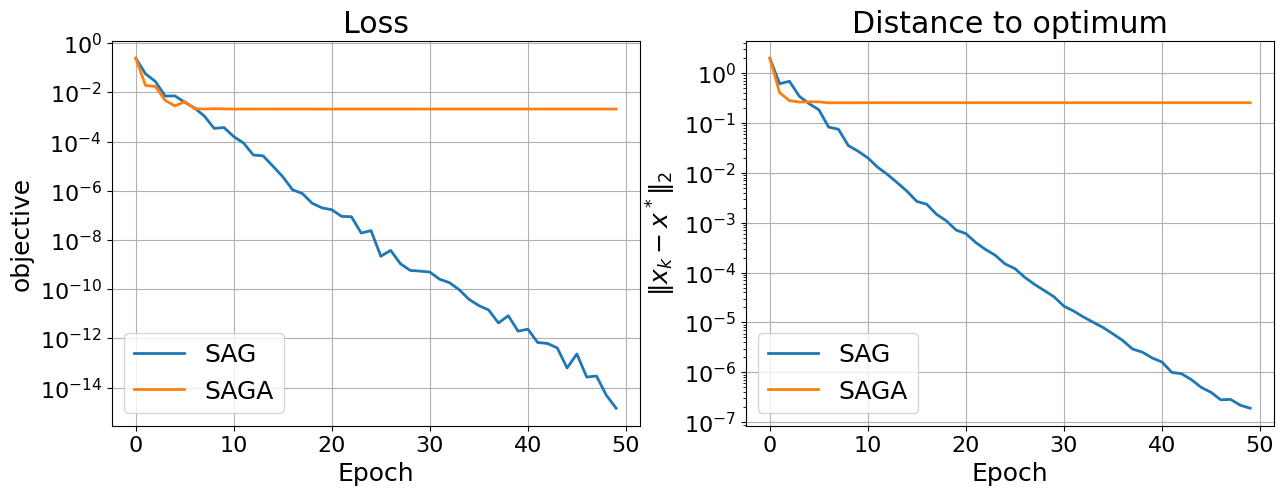

In [42]:
monitors = [monitor_sag, monitor_saga]

solvers = ["SAG", "SAGA"]

plot_epochs(monitors, solvers)

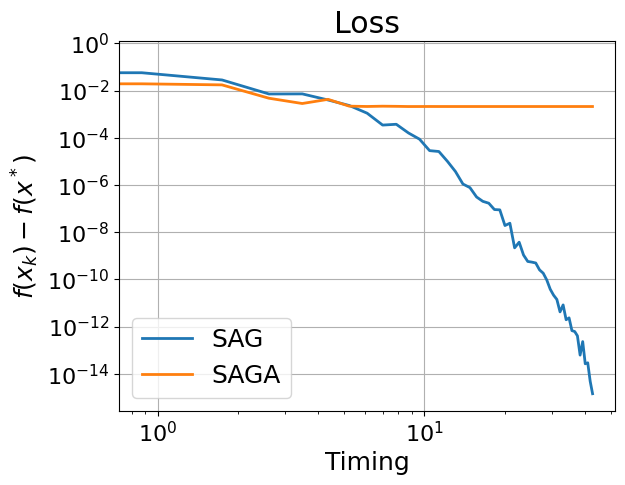

In [43]:
plot_time(monitors, solvers, xscale='log')

-----

### **SVRG**

We recall that an iteration of SVRG writes

For $k=1, \ldots, $ until convergence

1. Set $\tilde x \gets \tilde x^{(k)}$ and $x_1^{(k)} \gets \tilde x$
2. Compute $\mu_k \gets \nabla f(\tilde x)$
3. For $t=1, \ldots, n$
    4. Pick $i$ uniformly at random in $\{1, \ldots, n\}$
    5. Apply the step 
$$
x_{t+1}^{(k)} \gets x_t^{(k)} - \eta \big(\nabla f_{i}(x_t^{(k)}) - \nabla f_{i}(\tilde x) + \mu_k \big) 
$$

6. Set $\tilde x^{(k+1)} \gets x_{n+1}^{(k)}$

where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SVRG solver in the cell below

In [44]:
@njit
def svrg(x_init, random_indices, grad, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic variance reduction gradient algorithm."""
    x = x_init.copy()
    x_old = x.copy()
    x_list = []
    for idx in range(n_iter):
        
        ### TODO     
        mu_k = grad(x_old, *args)
        x = x_old.copy()
        
        for t in range(n):
            i = random_indices[idx]
            x -= step * (grad_i(i, x, *args) - grad_i(i, x_old, *args) + mu_k)
        
        x_old = x.copy()
        x = x_old

        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [45]:
x_init = np.zeros(d)
monitor_svrg = monitor(svrg, loss, x_min, (A, b ,lbda))
monitor_svrg.run(x_init, random_indices, grad, grad_i, n_iter * n, step, args=(A, b, lbda))

ValueError: array must not contain infs or NaNs

In [ ]:
monitors = [monitor_sgd, monitor_sgda, monitor_sag, monitor_saga, monitor_svrg]
solvers = ["SGD", "SGDA", "SAG", "SAGA", "SVRG"]
plot_epochs(monitors, solvers)

In [ ]:
plot_time(monitors, solvers)

----

<a id='comp'></a> 
## **5. Numerical comparison**

In [ ]:
monitors = [monitor_gd, monitor_agd,
            monitor_sgd, monitor_sgda,
            monitor_sag, monitor_saga, 
            monitor_svrg]

solvers = ["GD", "AGD", "SGD", "SGDA", "SAG", "SAGA", "SVRG"]

plot_epochs(monitors, solvers)

In [ ]:
plot_time(monitors, solvers, xscale='log')

----
<a id='conc'></a>
## **6. Conclusion**

*QUESTIONS*:
- Q1/ Compare and comment your results
- Q2/ Change the value of the ridge regularization (the ``lbda`` parameter) to low ridge $\lambda = 1 / n$ and high ridge regularization $\lambda = 1$ and compare your results. Comment.
- Q3/ Play also with the level of correlation between features (parameter ``corr`` above), and compare results with low and high correlation.
- Q4/ Conclude

### **Question 1: Comparison and comments of the results**

Q1/

- 

### **Question 2: Influence of the value of the ridge regularization (low ridge and high ridge)**

In [ ]:
lbda_list = [1. / n, 1.]
monitors_list = [[] for _ in lbda_list]
dict_algo_string = {gd: "GD", agd: "AGD", sgd: "SGD", sgda: "SGDA", sag: "SAG", saga:"SAGA", svrg: "SVRG"}

for i, lbda in enumerate(lbda_list):
    for algo in dict_algo_string.keys():
        if algo in [gd, agd]:
            step = 1. / lipschitz_linreg(A, b, lbda)
            x_init = np.zeros(d)
            monitor = monitor(algo, loss, x_min, (A, b ,lbda))
            monitor.run(x_init, grad, n_iter, step, args=(A, b, lbda))
        elif algo in [sgd, sgda]:
            step = 1e-1
            x_init = np.zeros(d)
            monitor = monitor(algo, loss, x_min, (A, b ,lbda))
            monitor.run(x_init, random_indices, grad_i, n_iter * n, step, args=(A, b, lbda))
        elif algo in [sag, saga]:
            max_squared_sum = np.max(np.sum(A ** 2, axis=1))
            step = 1.0 / (max_squared_sum + lbda)
            x_init = np.zeros(d)
            monitor = monitor(algo, loss, x_min, (A, b ,lbda))
            monitor.run(x_init, random_indices, grad_i, n_iter * n, step, args=(A, b, lbda))
        elif algo in [svrg]:
            step = 1. / lipschitz_linreg(A, b, lbda)
            x_init = np.zeros(d)
            monitor = monitor(algo, loss, x_min, (A, b ,lbda))
            monitor.run(x_init, random_indices, grad, grad_i, n_iter * n, step, args=(A, b, lbda))
        monitors[i].append(monitor)

# plot_epochs(monitors[0], dict_algo_string.values())
# plot_epochs(monitors[1], dict_algo_string.values())

# plot_time(monitors[0], dict_algo_string.values(), xscale='log')
# plot_time(monitors[1], dict_algo_string.values(), xscale='log')

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(22, 15))

for i, row_number in enumerate(np.transpose(np.array(monitors).squeeze)):
    for j, monitor in enumerate(monitors[i]):
        axes[0, i].semilogy(monitor.obj, lw=2, label = f"lbda = {lbda_list[j]}")
        axes[1, i].semilogy(monitor.err, lw=2, label = f"lbda = {lbda_list[j]}")

    axes[0, i].set_title(f"Distance to optimum ({dict_algo_string[gd]})")
    axes[0, i].set_xlabel("Epoch")
    axes[0, i].set_ylabel("$\|x_k - x^*\|_2$")*
    axes[0, i].legend()
    axes[0, i].grid()

    axes[1, i].set_title(f"Loss ({dict_algo_string[gd]})")
    axes[1, i].set_xlabel("Epoch")
    axes[1, i].set_ylabel("Loss")
    axes[1, i].legend()
    axes[1, i].grid()

plt.tight_layout()
plt.show()


Q2/

### **Question 3: Influence of the level of correlation between features (low and high correlation)** 

In [ ]:
corr_list = [0.1, 0.3, 0.7, 0.9]
monitors_list = [[] for _ in corr_list]

for i, corr in enumerate(corr_list):
    A, b = simu_linreg(x_model_truth, n, std=1., corr=corr)
    for algo in dict_algo_string.keys():
        step = 1. / lipschitz_linreg(A, b, lbda)
        x_init = np.zeros(d)
        monitor = monitor(algo, loss, x_min, (A, b ,lbda))
        monitor.run(x_init, random_indices, grad, grad_i, n_iter * n, step, args=(A, b, lbda))
        monitors_list[i].append(monitor)

plot_epochs(monitors_list[0], dict_algo_string.values())
plot_epochs(monitors_list[1], dict_algo_string.values())
plot_epochs(monitors_list[2], dict_algo_string.values())
plot_epochs(monitors_list[3], dict_algo_string.values())

plot_time(monitors_list[0], dict_algo_string.values(), xscale='log')
plot_time(monitors_list[1], dict_algo_string.values(), xscale='log')
plot_time(monitors_list[2], dict_algo_string.values(), xscale='log')
plot_time(monitors_list[3], dict_algo_string.values(), xscale='log')

Q3/

### **Question 4: Conclusion**

----

**Personal conclusion**: